## Download The COCO Dataset

In [ ]:
!git clone https://github.com/pdollar/coco/
%cd coco/PythonAPI
!make
!python setup.py install
%cd ../..
!rm -r coco

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/coco/PythonAPI
python setup.py build_ext --inplace
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wform

In [ ]:
%%capture
! sudo apt-get install aria2

In [ ]:
!aria2c -x 10 -j 10 http://images.cocodataset.org/zips/train2017.zip
!aria2c -x 10 -j 10 http://images.cocodataset.org/zips/val2017.zip
!aria2c -x 10 -j 10 http://images.cocodataset.org/annotations/annotations_trainval2017.zip


10/28 09:52:28 [NOTICE] Downloading 1 item(s)
 *** Download Progress Summary as of Sat Oct 28 09:53:30 2023 *** 
=
[#cd1907 4.5GiB/18GiB(25%) CN:5 DL:62MiB ETA:3m40s]
FILE: /content/train2017.zip
-

 *** Download Progress Summary as of Sat Oct 28 09:54:30 2023 *** 
=
[#cd1907 9.1GiB/18GiB(50%) CN:5 DL:78MiB ETA:1m54s]
FILE: /content/train2017.zip
-

 *** Download Progress Summary as of Sat Oct 28 09:55:31 2023 *** 
=
[#cd1907 13GiB/18GiB(77%) CN:5 DL:67MiB ETA:1m1s]
FILE: /content/train2017.zip
-


10/28 09:56:25 [NOTICE] Download complete: /content/train2017.zip

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
cd1907|OK  |    78MiB/s|/content/train2017.zip

Status Legend:
(OK):download completed.

10/28 09:56:25 [NOTICE] Downloading 1 item(s)

10/28 09:56:37 [NOTICE] Download complete: /content/val2017.zip

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=====================

In [ ]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
!unzip train2017.zip
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from PIL import Image
PATH_TO_TRAIN_DATA="./train2017"
PATH_TO_TRAIN_JSON="./annotations/instances_train2017.json"
PATH_TO_VAL_DATA="./val2017"
PATH_TO_VAL_JSON="./annotations/instances_val2017.json"
SIZE = 256

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [ ]:
train_paths = glob.glob("/content/train2017/*.jpg")
val_paths = glob.glob("/content/val2017/*.jpg")
print(len(train_paths), len(val_paths))

118287 5000


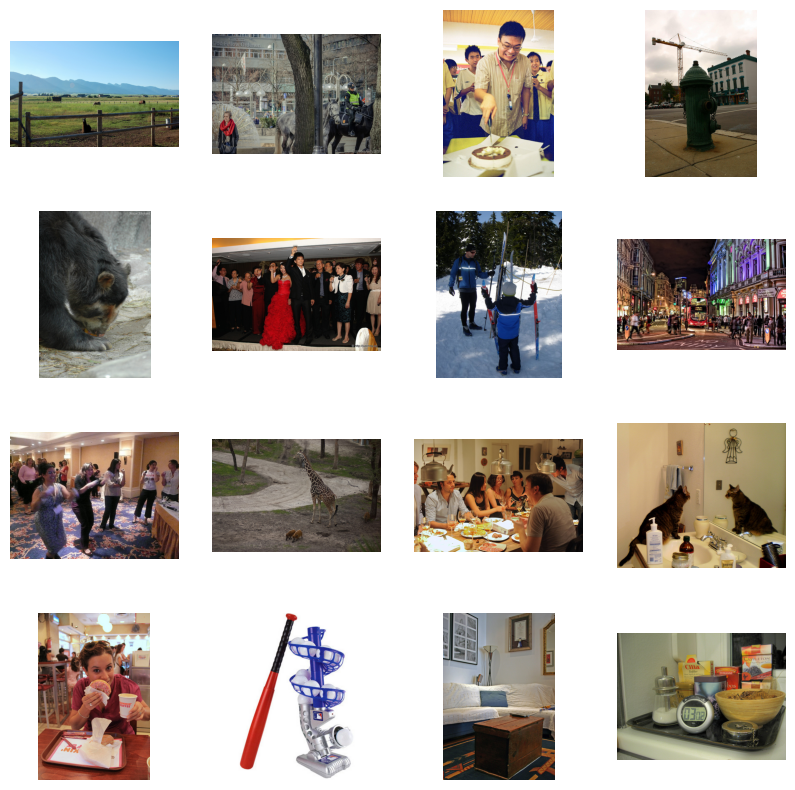

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
  def __init__(self, paths, split="train"):
    compose = [transforms.Resize((SIZE, SIZE), Image.BICUBIC)]
    if split == "train":
      compose.append(transforms.RandomHorizontalFlip())
    self.transforms = transforms.Compose(compose)
    self.split = split
    self.paths = paths

  def __getitem__(self, idx):
    img = Image.open(self.paths[idx]).convert("RGB")
    img = np.array(self.transforms(img))
    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)
    L = img_lab[[0], ...] / 50 - 1.
    ab = img_lab[[1, 2], ...] / 110.

    return {"L": L, "ab": ab}

  def __len__(self):
    return len(self.paths)

def make_dataloader(batch_size=128, n_workers=4, pin_memory=True, **kwargs):
  dataset = ColorizationDataset(paths=train_paths, split="train")
  dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory)
  return dataloader

In [ ]:
train_dl = make_dataloader(path=train_paths, split="train")
val_dl = make_dataloader(path=val_paths, split="val")

data = next(iter(train_dl))
Ls, abs_ = data["L"], data["ab"]
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([128, 1, 256, 256]) torch.Size([128, 2, 256, 256])
925 925


## Create Model

In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class UNet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UNetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UNetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UNetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UNetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

In [ ]:
class PatchDiscriminator(nn.Module):
  def __init__(self, input_c, num_filters=64, n_down=3):
    super().__init__()
    model = [self.get_layers(input_c, num_filters, norm=False)]
    model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) for i in range(n_down)]
    model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]
    self.model = nn.Sequential(*model)

  def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
    layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
    if norm:
      layers += [nn.BatchNorm2d(nf)]
    if act:
      layers += [nn.LeakyReLU(0.2, True)]
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256)
with torch.no_grad():
  out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
  def __init__(self, gan_mode="vanilla", real_label=1.0, fake_label=0.0):
    super().__init__()
    self.register_buffer("real_label", torch.tensor(real_label))
    self.register_buffer("fake_label", torch.tensor(fake_label))
    if gan_mode == "vanilla":
      self.loss = nn.BCEWithLogitsLoss()
    elif gan_mode == "lsgan":
      self.loss = nn.MSELoss()

  def get_labels(self, preds, target_is_real):
    labels = self.real_label if target_is_real else self.fake_label
    return labels.expand_as(preds)

  def __call__(self, preds, target_is_real):
    labels = self.get_labels(preds, target_is_real)
    loss = self.loss(preds, labels)
    return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
  def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
    super().__init__()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.lambda_L1 = lambda_L1
    self.net_G = init_model(UNet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device) if net_G is None else net_G.to(self.device)
    self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
    self.criterion = GANLoss(gan_mode="vanilla").to(device)
    self.l1_criterion = nn.L1Loss()
    self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
    self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

  def set_requires_grad(self, model, requires_grad=True):
    for p in model.parameters():
      p.requires_grad = requires_grad

  def setup_input(self, data):
    self.L = data["L"].to(self.device)
    self.ab = data["ab"].to(self.device)

  def forward(self):
    self.fake_color = self.net_G(self.L)

  def backward_D(self):
    fake_image = torch.cat([self.L, self.fake_color], dim=1)
    fake_preds = self.net_D(fake_image.detach())
    self.loss_D_fake = self.criterion(fake_preds, False)
    real_image = torch.cat([self.L, self.ab], dim=1)
    real_preds = self.net_D(real_image)
    self.loss_D_real = self.criterion(real_preds, True)
    self.loss_D = (self.loss_D_real + self.loss_D_fake) * 0.5
    self.loss_D.backward()

  def backward_G(self):
    fake_image = torch.cat([self.L, self.fake_color], dim=1)
    fake_preds = self.net_D(fake_image)
    self.loss_G_GAN = self.criterion(fake_preds, True)
    self.loss_G_L1 = self.l1_criterion(self.fake_color, self.ab) * self.lambda_L1
    self.loss_G = self.loss_G_GAN + self.loss_G_L1
    self.loss_G.backward()

  def optimize(self):
    self.forward()
    self.net_D.train()
    self.set_requires_grad(self.net_D, True)
    self.opt_D.zero_grad()
    self.backward_D()
    self.opt_D.step()

    self.net_G.train()
    self.set_requires_grad(self.net_D, False)
    self.opt_G.zero_grad()
    self.backward_G()
    self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

## Train Model

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/925 [00:00<?, ?it/s]


Epoch 1/100
Iteration 200/925
loss_D_fake: 0.49390
loss_D_real: 0.51183
loss_D: 0.50287
loss_G_GAN: 1.42574
loss_G_L1: 9.46606
loss_G: 10.89180


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


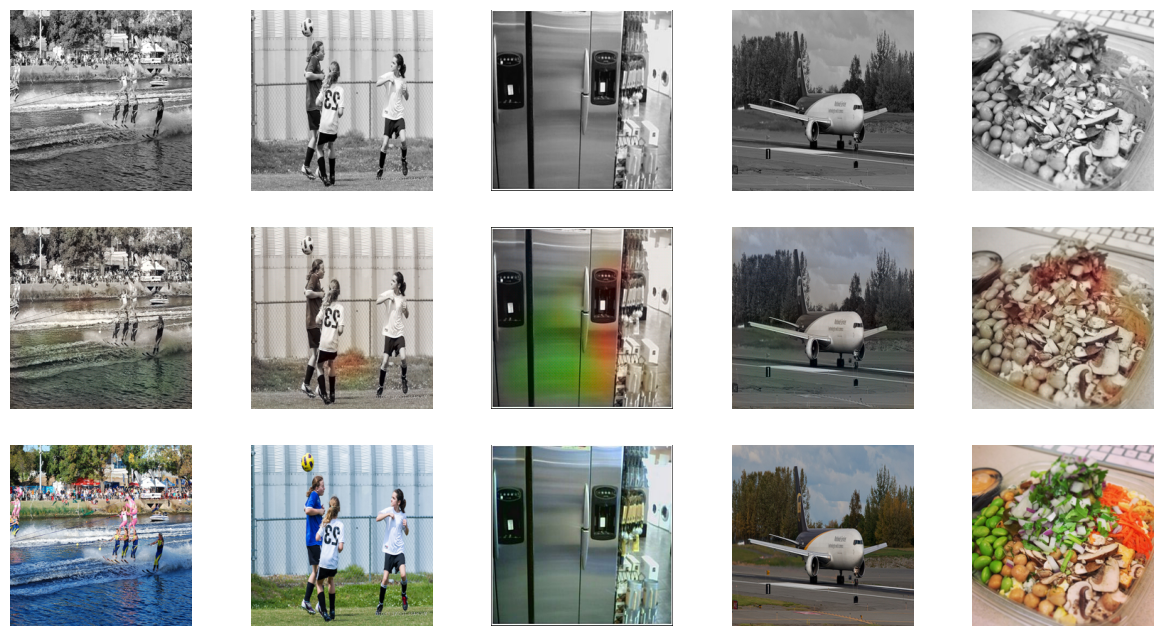


Epoch 1/100
Iteration 400/925
loss_D_fake: 0.50029
loss_D_real: 0.51792
loss_D: 0.50910
loss_G_GAN: 1.40196
loss_G_L1: 9.59560
loss_G: 10.99756


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return func(*args, **kwargs)


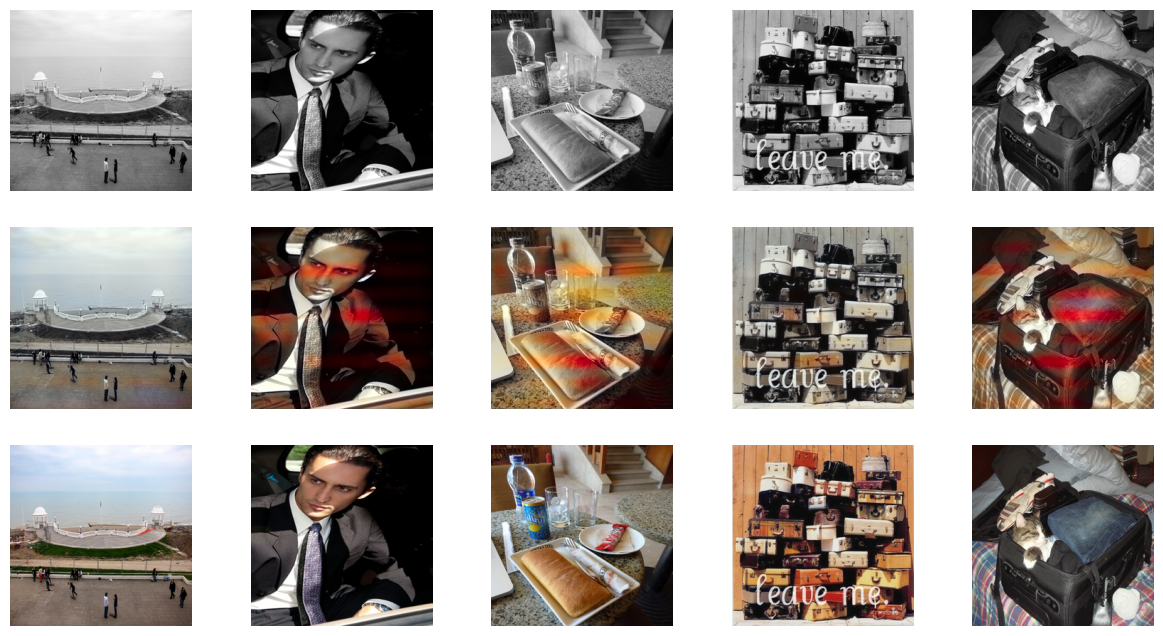

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
  data = next(iter(val_dl))
  for epoch in range(epochs):
    loss_meter_dict = create_loss_meters()
    i = 0
    for data in tqdm(train_dl):
      model.setup_input(data)
      model.optimize()
      update_losses(model, loss_meter_dict, count=data["L"].size(0))
      i += 1
      if i % display_every == 0:
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Iteration {i}/{len(train_dl)}")
        log_results(loss_meter_dict) # function to print out the losses
        visualize(model, data, save=False) # function displaying the model's outputs
        torch.save(model.state_dict(), "gan_colorization.pth")

model = MainModel()
train_model(model, train_dl, 100)

In [ ]:
torch.cuda.empty_cache()